# TP INF4248 - Classification d'images de déchets avec CNN

# Entraînement d'un CNN avec Keras
Basé sur le dataset realwaste :  

**Membres du groupe** :  
1. FETUE FOKO NATHANAEL - 21T2382  
2. DJONTHU DJONTHU MAURICE JUNIOR - 21T2557  
3. Essouma Mbarga Valerie constance - 18T2880  

# 🗑️ Entraînement d'un CNN sur RealWaste avec Keras  
**Objectif** : Classifier des images de déchets authentiques dans un environnement de décharge avec un réseau de neurones convolutif  

**Dataset** : RealWaste  
- 9 classes (types de matériaux : Cardboard, Food Organics, Glass, Metal, Miscellaneous Trash, Paper, Plastic, Textile Trash, Vegetation)  
- 4 752 images au total (524x524 pixels en couleur), capturées dans une décharge  
- Distribution inégale : de 318 (Textile Trash) à 921 (Plastic) images par classe  

**Approche** :  
1. Architecture CNN personnalisée (plusieurs couches convolutives avec dropout)  
2. Entraînement from scratch avec augmentation de données  
3. Évaluation des performances sur un ensemble de test  

In [42]:
import os
import shutil
import random
from pathlib import Path

# Chemins (à ajuster selon où tu décompresses RealWaste sur Kaggle ou localement)
data_dir = Path("/kaggle/input/realwaste/realwaste-main/RealWaste")  # Suppose que tu importes le dataset dans Kaggle
dataset_dir = Path("/kaggle/working/realwaste")
train_dir = dataset_dir / "train"
test_dir = dataset_dir / "test"

train_dir.mkdir(parents=True, exist_ok=True)
test_dir.mkdir(parents=True, exist_ok=True)

# Liste des classes de RealWaste
class_names = ["cardboard", "food_organics", "glass", "metal", "miscellaneous_trash", 
               "paper", "plastic", "textile_trash", "vegetation"]

# Parcourir les classes dans le dossier images
for class_dir in data_dir.iterdir():
    if class_dir.is_dir():
        class_name = class_dir.name
        images = list(class_dir.glob("*.jpg"))  # Récupérer toutes les images JPG
        
        # Mélanger et diviser les données (80% train, 20% test)
        random.shuffle(images)
        split_idx = int(0.8 * len(images))
        train_images, test_images = images[:split_idx], images[split_idx:]
        
        # Créer les dossiers de classes dans train et test
        (train_dir / class_name).mkdir(parents=True, exist_ok=True)
        (test_dir / class_name).mkdir(parents=True, exist_ok=True)
        
        # Déplacer les images
        for img in train_images:
            shutil.copy(img, train_dir / class_name / img.name)
        for img in test_images:
            shutil.copy(img, test_dir / class_name / img.name)

print("Dataset structuré avec succès !")

Dataset structuré avec succès !


In [43]:
from pathlib import Path

download_dir = Path('/kaggle/working')
print("a")

a


In [44]:
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Image augmentations
example_generator = ImageDataGenerator(
    rescale=1 / 255.,           # normalize pixel values between 0-1
    vertical_flip=True,         # vertical transposition
    horizontal_flip=True,       # horizontal transposition
    rotation_range=90,          # random rotation at 90 degrees
    height_shift_range=0.3,     # shift the height of the image 30%
    brightness_range=[0.1, 0.9] # specify the range in which to decrease/increase brightness
)

In [45]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_generator = ImageDataGenerator(
    rescale=1/255.,              # normalize pixel values between 0-1
    brightness_range=[0.1, 0.7], # specify the range in which to decrease/increase brightness
    width_shift_range=0.5,       # shift the width of the image 50%
    rotation_range=90,           # random rotation by 90 degrees
    horizontal_flip=True,        # 180 degree flip horizontally
    vertical_flip=True,          # 180 degree flip vertically
    validation_split=0.15        # 15% of the data will be used for validation at end of each epoch
)

In [46]:
import os

class_subset = sorted(os.listdir('/kaggle/input/realwaste/realwaste-main/RealWaste'))[:9]

In [47]:
BATCH_SIZE = 32

traingen = train_generator.flow_from_directory(download_dir/'realwaste/train',
                                               target_size=(128, 128),
                                               batch_size=BATCH_SIZE,
                                               class_mode='categorical',
                                               classes=class_subset,
                                               subset='training',
                                               shuffle=True,
                                               seed=42)

validgen = train_generator.flow_from_directory(download_dir/'realwaste/test',
                                               target_size=(128, 128),
                                               batch_size=BATCH_SIZE,
                                               class_mode='categorical',
                                               classes=class_subset,
                                               subset='validation',
                                               shuffle=True,
                                               seed=42)

Found 4037 images belonging to 9 classes.
Found 414 images belonging to 9 classes.


In [48]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Activation
from keras.regularizers import l1_l2

model = Sequential()

#### Input Layer ####
model.add(Conv2D(filters=32, kernel_size=(3,3), padding='same',
                 activation='relu', input_shape=(128, 128, 3)))

#### Convolutional Layers ####
model.add(Conv2D(32, (3,3), activation='relu'))
model.add(MaxPooling2D((2,2)))  # Pooling
model.add(Dropout(0.2)) # Dropout

model.add(Conv2D(64, (3,3), padding='same', activation='relu'))
model.add(Conv2D(64, (3,3), activation='relu'))
model.add(MaxPooling2D((2,2)))
model.add(Dropout(0.2))

model.add(Conv2D(128, (3,3), padding='same', activation='relu'))
model.add(Conv2D(128, (3,3), activation='relu'))
model.add(Activation('relu'))
model.add(MaxPooling2D((2,2)))
model.add(Dropout(0.2))

model.add(Conv2D(512, (5,5), padding='same', activation='relu'))
model.add(Conv2D(512, (5,5), activation='relu'))
model.add(MaxPooling2D((4,4)))
model.add(Dropout(0.2))

#### Fully-Connected Layer ####
model.add(Flatten())
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(len(class_subset), activation='softmax'))

model.summary() # a handy way to inspect the architecture

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_16 (Conv2D)                   │ (None, 128, 128, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_17 (Conv2D)                   │ (None, 126, 126, 32)        │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 63, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 63, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_18 (Conv2D)                   │ (None, 63, 63, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_19 (Conv2D)                   │ (None, 61, 61, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_11 (Dropout)                 │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_20 (Conv2D)                   │ (None, 30, 30, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_21 (Conv2D)                   │ (None, 28, 28, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_2 (Activation)            │ (None, 28, 28, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_10 (MaxPooling2D)      │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_12 (Dropout)                 │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_22 (Conv2D)                   │ (None, 14, 14, 512)         │       1,638,912 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_23 (Conv2D)                   │ (None, 10, 10, 512)         │       6,554,112 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_11 (MaxPooling2D)      │ (None, 2, 2, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_13 (Dropout)                 │ (None, 2, 2, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 1024)                │       2,098,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_14 (Dropout)                 │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 9)                   │           9,225 │
└──────────────────────────────────────┴─────────────────────────────┴──────────────

 Total params: 10,587,433 (40.39 MB)

 Trainable params: 10,587,433 (40.39 MB)

 Non-trainable params: 0 (0.00 B)

Nombre d'échantillons dans traingen : 4037
Nombre d'échantillons dans validgen : 414
Taille du batch (BATCH_SIZE) : 32
Steps per epoch : 126
Validation steps : 12
Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step - accuracy: 0.1653 - loss: 2.1752
Epoch 1: val_loss improved from inf to 2.15265, saving model to img_model.weights.best.weights.h5
126/126 ━━━━━━━━━━━━━━━━━━━━ 46s 279ms/step - accuracy: 0.1655 - loss: 2.1751 - val_accuracy: 0.1927 - val_loss: 2.1526
Epoch 2/100
  1/126 ━━━━━━━━━━━━━━━━━━━━ 4s 39ms/step - accuracy: 0.1562 - loss: 2.1553

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)



Epoch 2: val_loss improved from 2.15265 to 2.13836, saving model to img_model.weights.best.weights.h5
126/126 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.1562 - loss: 2.1553 - val_accuracy: 0.2333 - val_loss: 2.1384
Epoch 3/100
 13/126 ━━━━━━━━━━━━━━━━━━━━ 24s 215ms/step - accuracy: 0.1605 - loss: 2.1772
Epoch 5: val_loss improved from 2.06157 to 1.99052, saving model to img_model.weights.best.weights.h5
126/126 ━━━━━━━━━━━━━━━━━━━━ 30s 229ms/step - accuracy: 0.2178 - loss: 2.0870 - val_accuracy: 0.2891 - val_loss: 1.9905
Epoch 6/100
  1/126 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - accuracy: 0.2188 - loss: 2.1107
Epoch 6: val_loss did not improve from 1.99052
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 176us/step - accuracy: 0.2188 - loss: 2.1107 - val_accuracy: 0.1667 - val_loss: 2.0754
Epoch 7/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step - accuracy: 0.3161 - loss: 1.8696
Epoch 11: val_loss did not improve from 1.69590
126/126 ━━━━━━━━━━━━━━━━━━━━ 30s 226ms/step - accuracy: 0.3161 - loss: 1.869

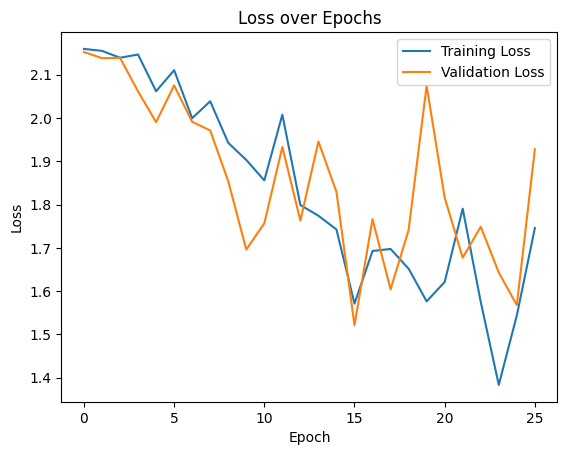

CPU times: user 7min 54s, sys: 6.31 s, total: 8min 1s
Wall time: 6min 54s


In [49]:
%%time

from keras.optimizers import RMSprop
from keras.callbacks import ModelCheckpoint, EarlyStopping
import matplotlib.pyplot as plt

# Vérification des générateurs (ajouté pour diagnostic)
print("Nombre d'échantillons dans traingen :", traingen.samples)
print("Nombre d'échantillons dans validgen :", validgen.samples)
print("Taille du batch (BATCH_SIZE) :", BATCH_SIZE)

steps_per_epoch = traingen.samples // BATCH_SIZE
val_steps = validgen.samples // BATCH_SIZE

# Assure au moins 1 step si le nombre d'échantillons est faible
steps_per_epoch = max(1, steps_per_epoch)
val_steps = max(1, val_steps)

print("Steps per epoch :", steps_per_epoch)
print("Validation steps :", val_steps)

n_epochs = 100

optimizer = RMSprop(learning_rate=0.0001)

model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# Sauvegarde des poids au format .weights.h5 (conforme aux versions récentes)
checkpointer = ModelCheckpoint(filepath='img_model.weights.best.weights.h5', 
                               verbose=1, 
                               save_best_only=True,
                               save_weights_only=True)

# Arrêt anticipé
early_stop = EarlyStopping(monitor='val_loss',
                           patience=10,
                           restore_best_weights=True,
                           mode='min')

# Entraînement du modèle
history = model.fit(traingen,
                    epochs=n_epochs, 
                    steps_per_epoch=steps_per_epoch,
                    validation_data=validgen,
                    validation_steps=val_steps,
                    callbacks=[early_stop, checkpointer],
                    verbose=1)  # verbose=1 pour voir la progression

# Visualisation avec matplotlib
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.show()

In [50]:
test_generator = ImageDataGenerator(rescale=1/255.)

testgen = test_generator.flow_from_directory(download_dir/'realwaste/test',
                                             target_size=(128, 128),
                                             batch_size=1,
                                             class_mode=None,
                                             classes=class_subset, 
                                             shuffle=False,
                                             seed=42)

Found 2798 images belonging to 9 classes.


In [55]:
import numpy as np

# Charger les poids (assure-toi que le fichier existe)
model.load_weights('img_model.weights.best.weights.h5')

# Faire les prédictions (probabilités pour chaque classe)
predictions = model.predict(testgen)

# Extraire les classes prédites en prenant l'indice de la probabilité maximale
predicted_classes = np.argmax(predictions, axis=1)

# Récupérer les indices et noms des classes
class_indices = traingen.class_indices
class_indices = dict((v, k) for k, v in class_indices.items())
true_classes = testgen.classes

# Afficher quelques exemples pour vérification
print("Classes prédites (5 premières) :", [class_indices[i] for i in predicted_classes[:5]])
print("Classes réelles (5 premières) :", [class_indices[i] for i in true_classes[:5]])

2798/2798 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step
Classes prédites (5 premières) : ['Metal', 'Plastic', 'Food Organics', 'Plastic', 'Vegetation']
Classes réelles (5 premières) : ['Cardboard', 'Cardboard', 'Cardboard', 'Cardboard', 'Cardboard']


In [56]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_fscore_support, accuracy_score

def display_results(y_true, y_preds, class_labels):
    
    results = pd.DataFrame(precision_recall_fscore_support(y_true, y_preds),
                          columns=class_labels).T

    results.rename(columns={0: 'Precision', 1: 'Recall',
                            2: 'F-Score', 3: 'Support'}, inplace=True)
    
    results.sort_values(by='F-Score', ascending=False, inplace=True)                           
    global_acc = accuracy_score(y_true, y_preds)
    
    print("Overall Categorical Accuracy: {:.2f}%".format(global_acc*100))
    return results

def plot_predictions(y_true, y_preds, test_generator, class_indices):

    fig = plt.figure(figsize=(20, 10))
    for i, idx in enumerate(np.random.choice(test_generator.samples, size=20, replace=False)):
        ax = fig.add_subplot(4, 5, i + 1, xticks=[], yticks=[])
        ax.imshow(np.squeeze(test_generator[idx]))
        pred_idx = y_preds[idx]
        true_idx = y_true[idx]
                
        plt.tight_layout()
        ax.set_title("{}\n({})".format(class_indices[pred_idx], class_indices[true_idx]),
                     color=("green" if pred_idx == true_idx else "red"))

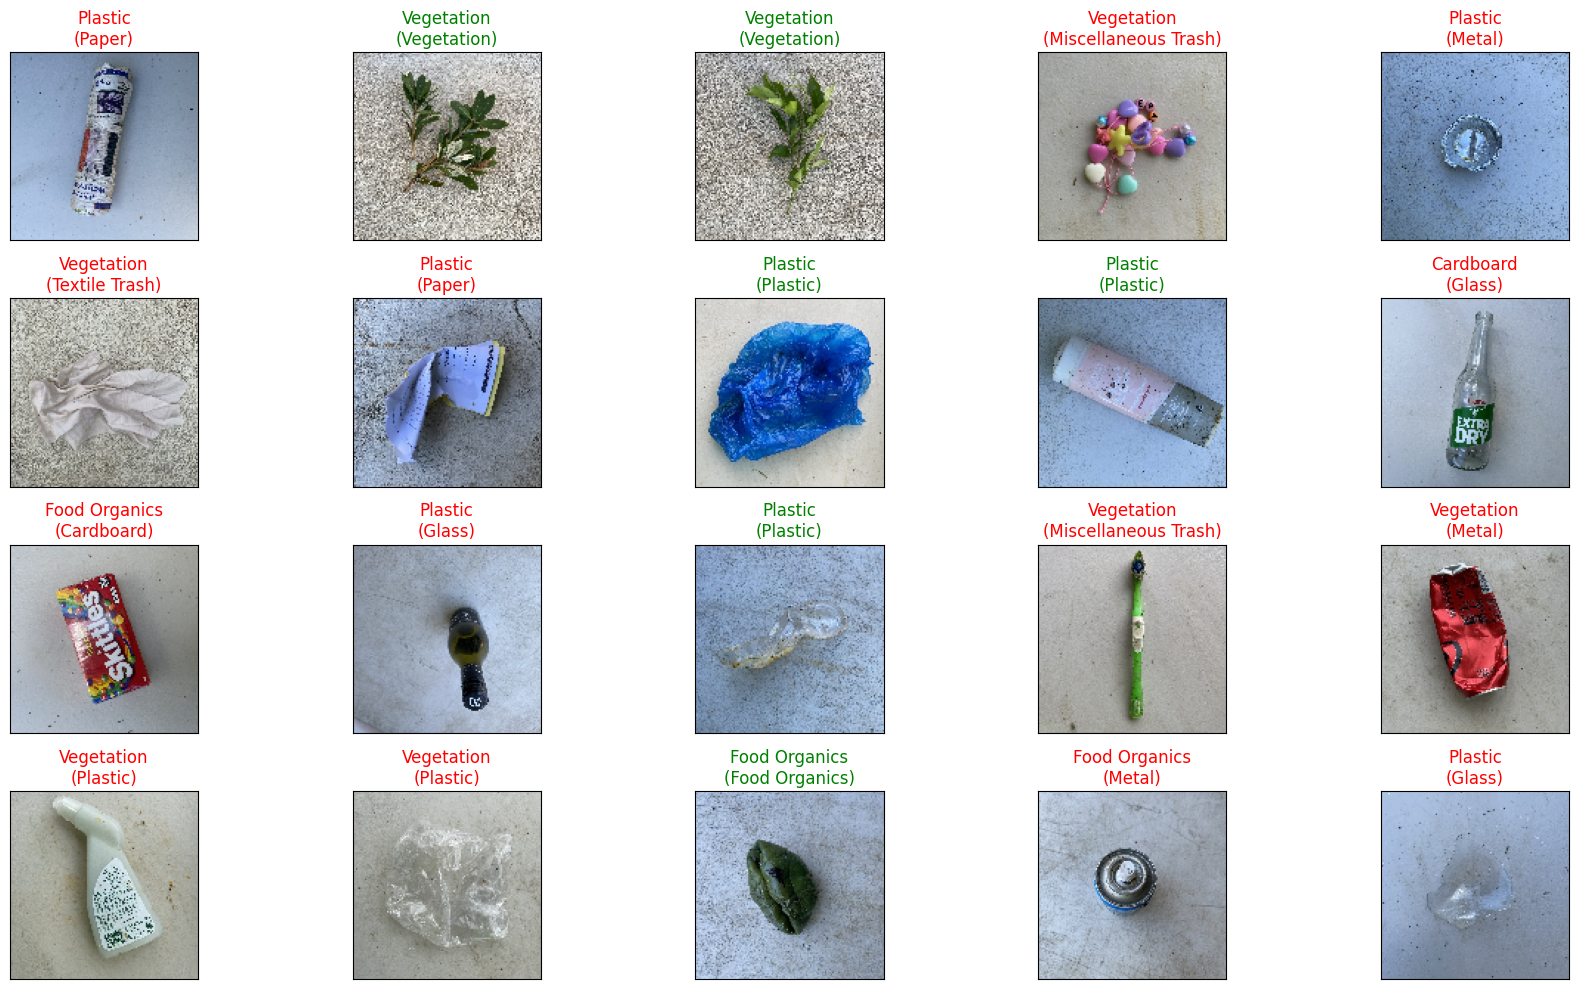

In [57]:
plot_predictions(true_classes, predicted_classes, testgen, class_indices)

In [58]:
display_results(true_classes, predicted_classes, class_indices.values())

Overall Categorical Accuracy: 22.84%


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,Precision,Recall,F-Score,Support
Plastic,0.308989,0.405157,0.350598,543.0
Vegetation,0.169960,0.996139,0.290377,259.0
Food Organics,0.208877,0.313725,0.250784,255.0
Cardboard,0.679245,0.136364,0.227129,264.0
Paper,0.337079,0.104895,0.160000,286.0
Metal,0.317073,0.027542,0.050682,472.0
Glass,1.000000,0.008230,0.016327,243.0
Miscellaneous Trash,0.000000,0.000000,0.000000,286.0
Textile Trash,0.000000,0.000000,0.000000,190.0
